<a href="https://colab.research.google.com/github/Oreki820/-Desafio-Riot-Games-Previs-o-de-Vit-rias-no-League-of-Legends/blob/main/riot_lol_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 🎮 Desafio Riot Games (League of Legends) — Previsão de Vitórias
**Objetivo**: Desenvolver um modelo de classificação capaz de prever se o time azul vence uma partida de **League of Legends**, utilizando **apenas dados pós-início de jogo** (ex.: *first blood*, torres, dragões).  

> **Variável-alvo**: `blueWins` (1 = vitória do time azul, 0 = derrota)

---

## 📦 Dataset
```
gameId, blueWins, blueWardsPlaced, blueWardsDestroyed, blueFirstBlood,
blueKills, blueDeaths, blueAssists, blueEliteMonsters, blueDragons, ...
redTowersDestroyed, redTotalGold, redAvgLevel, redTotalExperience,
redTotalMinionsKilled, redTotalJungleMinionsKilled, redGoldDiff,
redExperienceDiff, redCSPerMin, redGoldPerMin
```
---


## 🧱 Parte 1 – Importação e Carregamento
Nesta seção, importei bibliotecas essenciais (Pandas, NumPy, Matplotlib, Seaborn, Scikit-Learn), configurei estilo de gráficos e carreguei o dataset.


In [1]:

# importei bibliotecas e configurei estilo de gráficos
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             roc_curve, ConfusionMatrixDisplay, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

# Upload de arquivo
try:
    from google.colab import files
    uploaded = files.upload()
    csv_name = list(uploaded.keys())[0]
except Exception as e:
    print('Execução fora do Colab ou upload não realizado. Defina csv_name manualmente.')
    csv_name = 'seu_arquivo.csv'  # Ajuste aqui, se necessário

# Carregamento do dataset
try:
    df = pd.read_csv(csv_name)
except Exception as e:
    print(f'Erro ao ler {csv_name}:', e)
    # Cria um DF de exemplo vazio (para não quebrar o notebook)
    df = pd.DataFrame()

print('Dimensões do dataset:', df.shape)
display(df.head())
print("\nDescrição da variável-alvo: 'blueWins' (1 = vitória blue, 0 = derrota)")


Saving Base_M43_Pratique_LOL_RANKED_WIN.csv to Base_M43_Pratique_LOL_RANKED_WIN.csv
Dimensões do dataset: (9879, 40)


,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0,15,6,0,6,9,8,0,0,0,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2,12,1,1,5,5,2,2,1,1,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3,15,3,1,11,7,14,0,0,0,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,1,0,15157,7.0,17954,201,55,-1321,-7,20.1,1515.7,15,2,1,5,4,10,0,0,0,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,0,0,16400,7.0,18543,210,57,-1004,230,21.0,1640.0,17,2,1,6,6,7,1,1,0,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4



Descrição da variável-alvo: 'blueWins' (1 = vitória blue, 0 = derrota)


---


## 🧼 Parte 2 – Limpeza e Pré-processamento
- Verifiquei valores ausentes
- Removi colunas irrelevantes (`gameId`)
- Conferi tipos (numéricos/binários)
- Tratrei *outliers* (se necessário, ex.: *winsorization* simples)
- Normalizei/padronizei variáveis numéricas (via `StandardScaler` no pipeline)


In [2]:

# Copiei o DataFrame para evitar efeitos colaterais
df_clean = df.copy()

# Valores ausentes
print('Valores ausentes por coluna:')
display(df_clean.isnull().sum().sort_values(ascending=False))

# Colunas irrelevantes
for col_drop in ['gameId']:
    if col_drop in df_clean.columns:
        df_clean.drop(columns=[col_drop], inplace=True)

# Assegura que a coluna-alvo existe
if 'blueWins' not in df_clean.columns:
    raise ValueError("A coluna 'blueWins' não foi encontrada. Verifique seu CSV.")

# Tipos de dados
print('\nTipos de dados:')
display(df_clean.dtypes)

# Tratamento simples de outliers
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != 'blueWins']  # não aplicar na target

def winsorize_series(s, lower_q=0.01, upper_q=0.99):
    if s.nunique() <= 2:  # pula colunas binárias
        return s
    low, high = s.quantile(lower_q), s.quantile(upper_q)
    return s.clip(lower=low, upper=high)

df_clean[numeric_cols] = df_clean[numeric_cols].apply(winsorize_series)

print('\nApós Winsorization (1%–99%) nas colunas numéricas contínuas.')
display(df_clean.describe().T)


Valores ausentes por coluna:


,0
gameId,0
blueWins,0
blueWardsPlaced,0
blueWardsDestroyed,0
blueFirstBlood,0
blueKills,0
blueDeaths,0
blueAssists,0
blueEliteMonsters,0
blueDragons,0



Tipos de dados:


,0
blueWins,int64
blueWardsPlaced,int64
blueWardsDestroyed,int64
blueFirstBlood,int64
blueKills,int64
blueDeaths,int64
blueAssists,int64
blueEliteMonsters,int64
blueDragons,int64
blueHeralds,int64



Após Winsorization (1%–99%) nas colunas numéricas contínuas.


,count,mean,std,min,25%,50%,75%,max
blueWins,9879.0,0.499038,0.500024,0.000,0.00,0.0,1.00,1.000
blueWardsPlaced,9879.0,21.988359,16.024972,10.000,14.00,16.0,20.00,105.000
blueWardsDestroyed,9879.0,2.776496,1.894315,0.000,1.00,3.0,4.00,11.000
blueFirstBlood,9879.0,0.504808,0.500002,0.000,0.00,1.0,1.00,1.000
blueKills,9879.0,6.172993,2.945708,1.000,4.00,6.0,8.00,14.000
blueDeaths,9879.0,6.132605,2.880531,1.000,4.00,6.0,8.00,14.000
blueAssists,9879.0,6.612410,3.949916,0.000,4.00,6.0,9.00,18.000
blueEliteMonsters,9879.0,0.549954,0.625527,0.000,0.00,0.0,1.00,2.000
blueDragons,9879.0,0.361980,0.480597,0.000,0.00,0.0,1.00,1.000
blueHeralds,9879.0,0.187974,0.390712,0.000,0.00,0.0,0.00,1.000


---


## 📊 Parte 3 – Análise Exploratória (EDA)
- Distribuição de `blueWins`
- Correlação com o alvo (heatmap)
- Estatísticas descritivas (médias, desvios)
- Visualização de variáveis binárias chave (`blueFirstBlood`, `blueDragons`, etc.)
- Comparação Azul × Vermelho (ex.: somatórios médios por time)


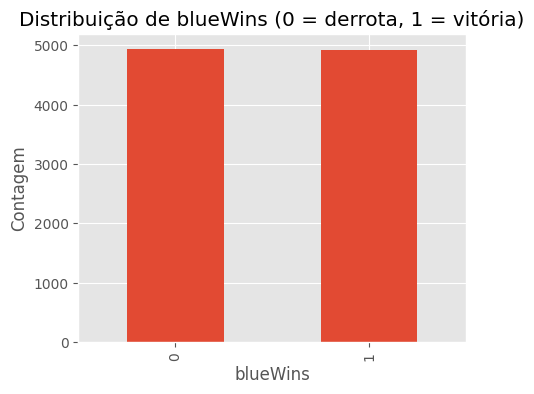

Correlação com blueWins (desc):


,blueWins
blueWins,1.000000
blueGoldDiff,0.514978
blueExperienceDiff,0.493096
blueTotalGold,0.419251
blueGoldPerMin,0.419251
blueTotalExperience,0.399156
blueAvgLevel,0.360017
redDeaths,0.337958
blueKills,0.337958
blueAssists,0.279084


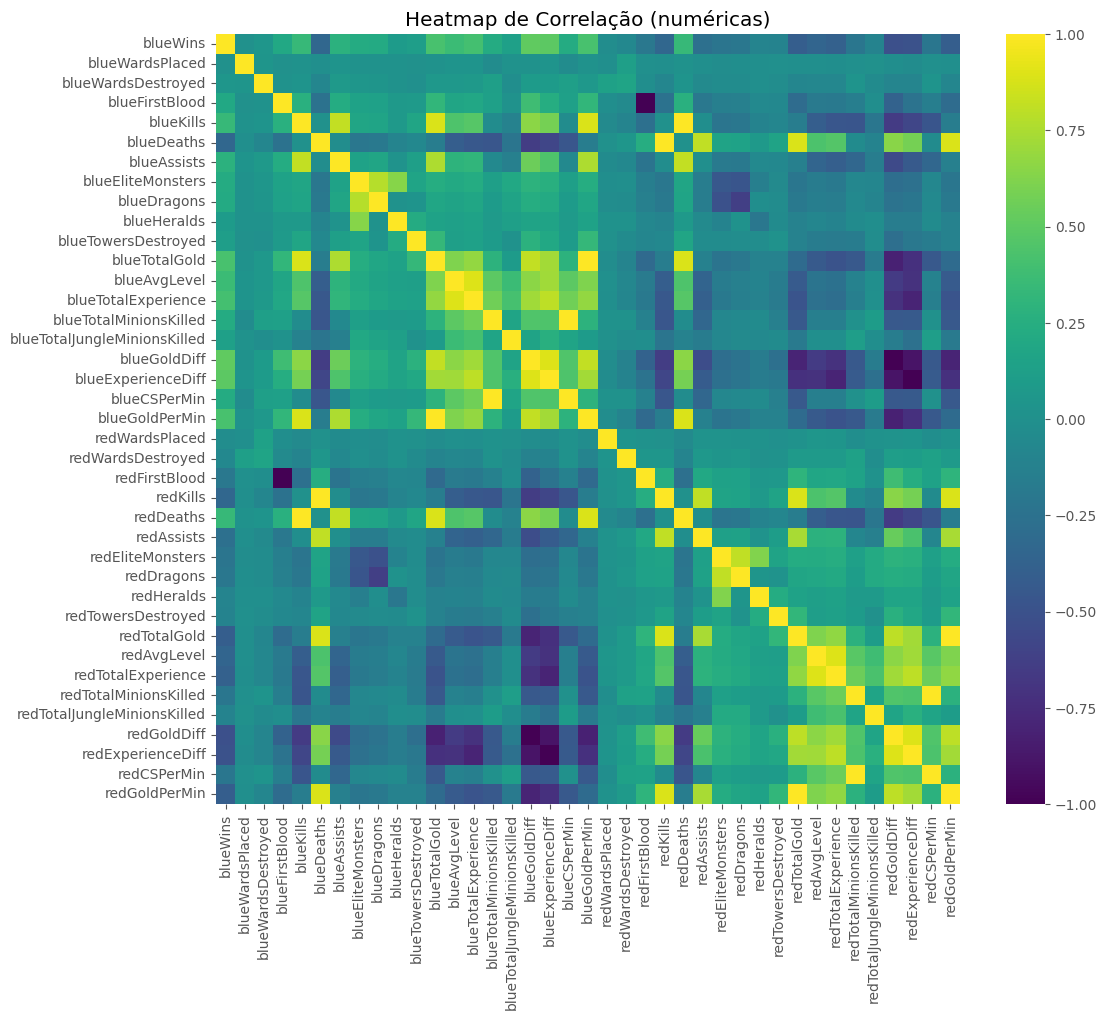

,count,mean,std,min,25%,50%,75%,max
blueWins,9879.0,0.499038,0.500024,0.000,0.00,0.0,1.00,1.000
blueWardsPlaced,9879.0,21.988359,16.024972,10.000,14.00,16.0,20.00,105.000
blueWardsDestroyed,9879.0,2.776496,1.894315,0.000,1.00,3.0,4.00,11.000
blueFirstBlood,9879.0,0.504808,0.500002,0.000,0.00,1.0,1.00,1.000
blueKills,9879.0,6.172993,2.945708,1.000,4.00,6.0,8.00,14.000
blueDeaths,9879.0,6.132605,2.880531,1.000,4.00,6.0,8.00,14.000
blueAssists,9879.0,6.612410,3.949916,0.000,4.00,6.0,9.00,18.000
blueEliteMonsters,9879.0,0.549954,0.625527,0.000,0.00,0.0,1.00,2.000
blueDragons,9879.0,0.361980,0.480597,0.000,0.00,0.0,1.00,1.000
blueHeralds,9879.0,0.187974,0.390712,0.000,0.00,0.0,0.00,1.000


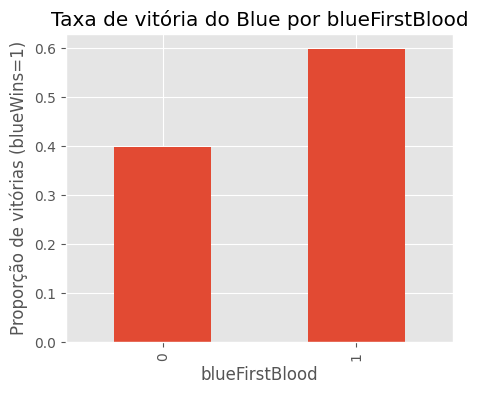

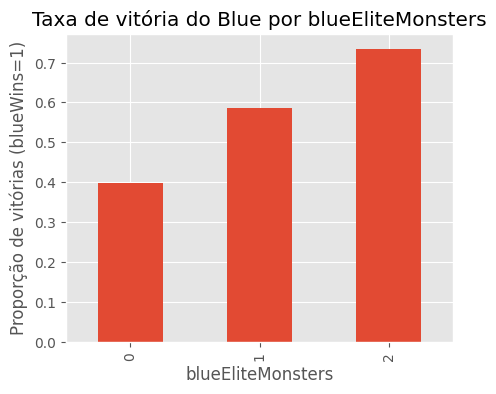

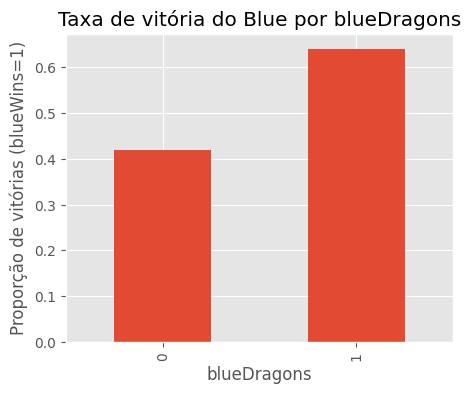

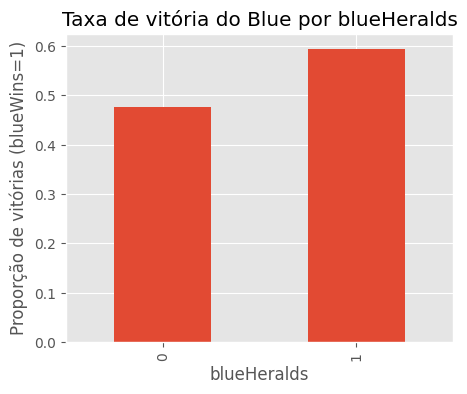

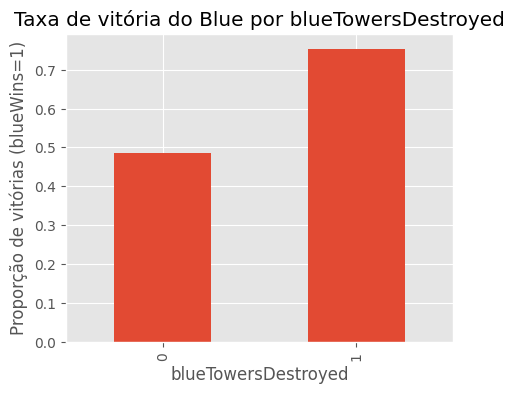

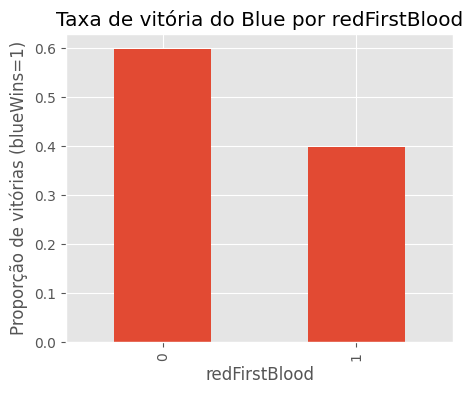

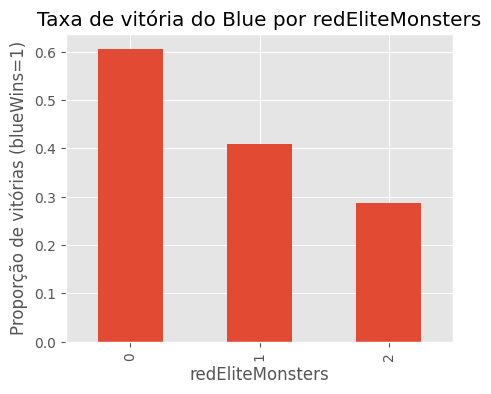

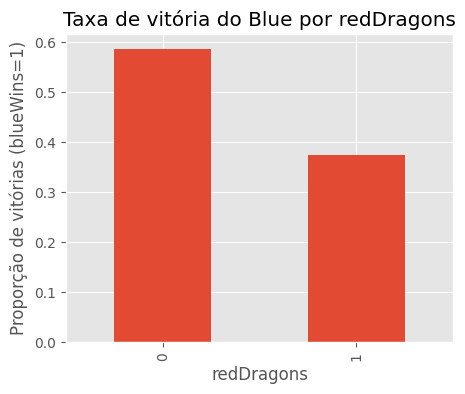

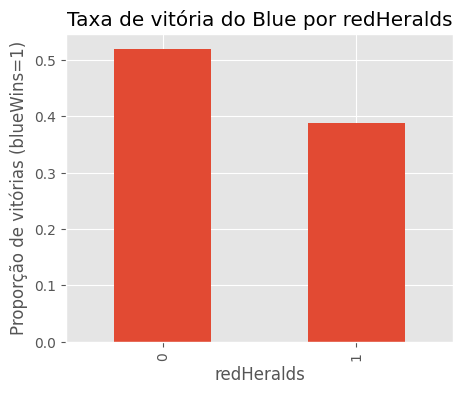

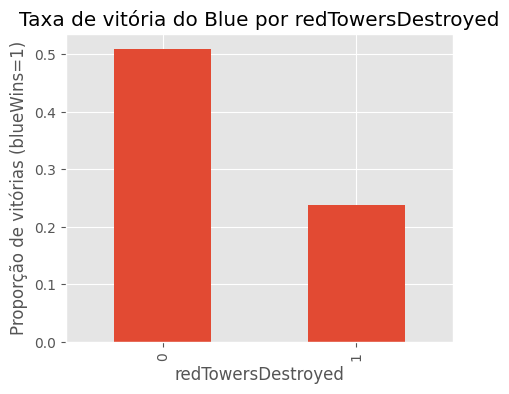

Médias gerais (ex.: para colunas blue* e red*):


,mean
blueWins,0.499038
blueWardsPlaced,21.988359
blueWardsDestroyed,2.776496
blueFirstBlood,0.504808
blueKills,6.172993
blueDeaths,6.132605
blueAssists,6.612410
blueEliteMonsters,0.549954
blueDragons,0.361980
blueHeralds,0.187974


In [3]:

# Distribuição da variável-alvo
fig, ax = plt.subplots(figsize=(5,4))
df_clean['blueWins'].value_counts().sort_index().plot(kind='bar', ax=ax)
ax.set_title('Distribuição de blueWins (0 = derrota, 1 = vitória)')
ax.set_xlabel('blueWins')
ax.set_ylabel('Contagem')
plt.show()

# Correlação com o alvo
corr = df_clean.corr(numeric_only=True)
if 'blueWins' in corr.columns:
    target_corr = corr['blueWins'].sort_values(ascending=False)
    print('Correlação com blueWins (desc):')
    display(target_corr)

    # Heatmap de correlação completa
    plt.figure(figsize=(12,10))
    sns.heatmap(corr, cmap='viridis', annot=False)
    plt.title('Heatmap de Correlação (numéricas)')
    plt.show()

# Estatísticas descritivas
display(df_clean.describe().T)

# Visualização de algumas variáveis binárias/básicas
bin_like = [c for c in df_clean.columns if df_clean[c].nunique() <= 5 and c != 'blueWins']
bin_like = bin_like[:10]  # limita para visual compacto
for col in bin_like:
    fig, ax = plt.subplots(figsize=(5,4))
    df_clean.groupby(col)['blueWins'].mean().plot(kind='bar', ax=ax)
    ax.set_title(f'Taxa de vitória do Blue por {col}')
    ax.set_ylabel('Proporção de vitórias (blueWins=1)')
    plt.show()

# Comparação Azul × Vermelho
candidates_blue = [c for c in df_clean.columns if c.startswith('blue')]
candidates_red  = [c for c in df_clean.columns if c.startswith('red')]

agg_funcs = {c: 'mean' for c in candidates_blue + candidates_red if c in df_clean.columns}
if agg_funcs:
    means = df_clean.agg(agg_funcs)
    print('Médias gerais (ex.: para colunas blue* e red*):')
    display(means.to_frame('mean'))


## 📊 **Insights da Parte 3 — Análise Exploratória (EDA)**

### 🎯 Distribuição da variável-alvo `blueWins`
O conjunto de dados apresenta **quase 5.000 vitórias e 5.000 derrotas**, com o valor `0` (derrota do time azul) **ligeiramente superior** ao `1` (vitória).  
Isso indica um **equilíbrio quase perfeito** entre as classes, o que é positivo para os modelos de classificação.  
*(ver gráfico de barras: distribuição de blueWins)*

---

### 🔗 **Correlação com `blueWins` (descendente)**
As variáveis mais fortemente correlacionadas com a vitória do time azul são:
- 🟢 `blueGoldDiff` (**0.51**) — quanto maior a diferença de ouro a favor do azul, maior a chance de vitória.  
- 🟢 `blueExperienceDiff` (**0.49**) — vantagem de experiência é um forte indicador de performance.  
- 🟢 `blueTotalGold`, `blueGoldPerMin` e `blueTotalExperience` (**≈0.4**) também aparecem como fatores de peso.  
- 🔴 Variáveis do time vermelho (como `redGoldDiff`, `redExperienceDiff`, `redTotalGold`) apresentam **correlação negativa equivalente**, reforçando o caráter espelhado das métricas.  

Em resumo, **vantagens de ouro e experiência** estão diretamente ligadas às vitórias do time azul, enquanto os mesmos indicadores em vermelho correspondem às derrotas do azul.  
*(ver heatmap de correlação)*

---

### ⚔️ **Análise de Eventos-Chave**

#### 💥 `blueFirstBlood`
- `1` → 0.6 de taxa de vitória  
- `0` → 0.4  
➡️ O **First Blood** dá ao time azul uma **vantagem inicial relevante**, aumentando suas chances de vitória em cerca de **20 pontos percentuais**.

#### 🐉 `blueEliteMonsters`
- `0` → 0.4  
- `1` → 0.6 (ligeiramente abaixo do 0.6 exato)  
- `2` → 0.7 (ligeiramente acima do 0.7)  
➡️ A conquista de **monstros épicos (Dragões/Barões/Heralds)** aumenta progressivamente a probabilidade de vitória.

#### 🐲 `blueDragons`
- `0` → 0.4  
- `1` → 0.6  
➡️ Cada dragão capturado **eleva significativamente** a taxa de vitória — reforçando a importância do controle de objetivos neutros.

#### 🪓 `blueHeralds`
- `0` → 0.5  
- `1` → 0.6 (um leve aumento)  
➡️ O uso do **Arauto** ajuda a garantir pressão no mapa e vantagem estrutural.

#### 🏰 `blueTowersDestroyed`
- `0` → 0.5  
- `1` → 0.7  
➡️ A destruição da **primeira torre** mostra-se um **indicador fortíssimo de vitória**, refletindo controle de mapa e avanço estratégico.

---

### 🔴 **Indicadores Negativos (Time Vermelho)**

#### 💀 `redFirstBlood`
- `0` → 0.6 (vantagem para azul)  
- `1` → 0.4  
➡️ Se o time vermelho consegue o First Blood, **a taxa de vitória do azul cai 20 pontos** — mesmo efeito inverso ao caso azul.

#### 🐉 `redEliteMonsters`
- `0` → 0.6  
- `1` → 0.4  
- `2` → 0.3  
➡️ Quanto mais monstros o vermelho conquista, **menor a chance de vitória do azul**.

#### 🐲 `redDragons`
- `0` → 0.6  
- `1` → 0.4  
➡️ Cada dragão conquistado pelo vermelho **reduz consideravelmente** a taxa de vitória do azul.

#### 🪓 `redHeralds`
- `0` → 0.5  
- `1` → 0.4  
➡️ O domínio do **Arauto** pelo vermelho tem **efeito negativo** direto na performance azul.

#### 🏰 `redTowersDestroyed`
- `0` → 0.5  
- `1` → 0.2  
➡️ Quando o vermelho destrói torres, o azul **quase sempre perde** — refletindo perda total de controle de mapa.

---

### 📈 **Médias Gerais — Blue × Red**
| Métrica | Blue | Red | Observação |
|----------|-------|------|------------|
| 🧱 **Vitórias (blueWins)** | 0.499 | — | Balanço quase perfeito entre vitórias e derrotas. |
| 🪙 **Total Gold** | 16,498 | 16,486 | Times têm médias próximas, mas diferenças determinam o resultado. |
| 🧩 **Avg Level** | 6.91 | 6.92 | Times equilibrados; pequenas diferenças indicam vantagem de XP. |
| ⚔️ **Kills/Deaths** | 6.17 / 6.13 | 6.13 / 6.17 | Balanço quase idêntico entre abates e mortes. |
| 🐉 **Dragons** | 0.36 | 0.41 | Vermelho leva mais dragões em média — porém com menor impacto no resultado. |
| 🪓 **Heralds** | 0.18 | 0.16 | Azul ligeiramente superior. |
| 🏰 **Towers Destroyed** | 0.04 | 0.04 | Equilíbrio, mas quando há destruição, o impacto é muito alto. |
| 💰 **Gold Diff** | +11.9 | -11.9 | Diferença simétrica: ouro é o maior preditor de vitória. |
| 📊 **Experience Diff** | -34.1 | +34.1 | Relação espelhada idêntica à diferença de ouro. |

---

### 🧩 **Resumo dos Insights**
- A **vitória do time azul** está fortemente associada à **vantagem em ouro, experiência e objetivos** (dragões, torres, monstros épicos).  
- **Eventos iniciais**, como o **First Blood**, têm impacto duradouro na probabilidade de vitória.  
- Quando o **vermelho domina os objetivos**, a chance de vitória do azul despenca rapidamente.  
- As métricas espelhadas (ouro e XP) confirmam que **pequenas vantagens acumuladas cedo** são decisivas no LoL competitivo.  

> 💡 *Conclusão*: os resultados sugerem que **controle de mapa + objetivos neutros** são os fatores mais determinantes para prever vitórias do time azul.

---


## ⚙️ Parte 4 – Divisão e Preparação dos Dados
- Separei **X** (features) e **y** (target)
- `train_test_split(test_size=0.2, random_state=42)`
- Escalonamento via `StandardScaler` dentro de `Pipeline`


In [4]:

# Separa X e y
X = df_clean.drop(columns=['blueWins'])
y = df_clean['blueWins'].astype(int)

# Treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

numeric_features = X_train.columns.tolist()

scaler = StandardScaler()
preprocess = ColumnTransformer(
    transformers=[('num', scaler, numeric_features)],
    remainder='drop'
)
print('Shapes -> X_train:', X_train.shape, '| X_test:', X_test.shape)


Shapes -> X_train: (7903, 38) | X_test: (1976, 38)


---


## 🧠 Parte 5 – Modelagem (LogReg, Naive Bayes, Árvore)
- Ajuste (fit)
- Predições (`predict`, `predict_proba`)
- Métricas: **Accuracy, Precision, Recall, F1, ROC AUC**
- Curvas ROC dos 3 modelos no mesmo gráfico



=== LogisticRegression ===
              precision    recall  f1-score   support

           0     0.7206    0.7061    0.7133       990
           1     0.7107    0.7252    0.7179       986

    accuracy                         0.7156      1976
   macro avg     0.7157    0.7156    0.7156      1976
weighted avg     0.7157    0.7156    0.7156      1976



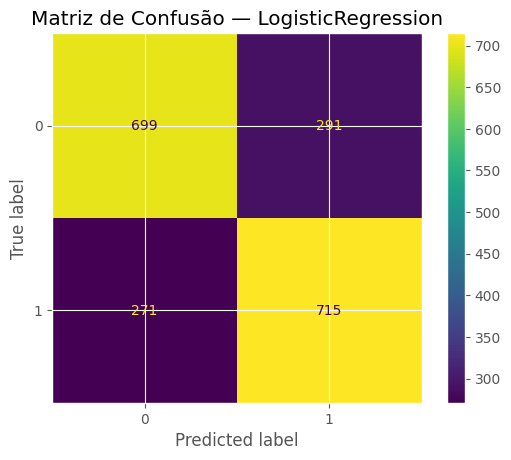


=== GaussianNB ===
              precision    recall  f1-score   support

           0     0.7179    0.7222    0.7200       990
           1     0.7194    0.7150    0.7172       986

    accuracy                         0.7186      1976
   macro avg     0.7186    0.7186    0.7186      1976
weighted avg     0.7186    0.7186    0.7186      1976



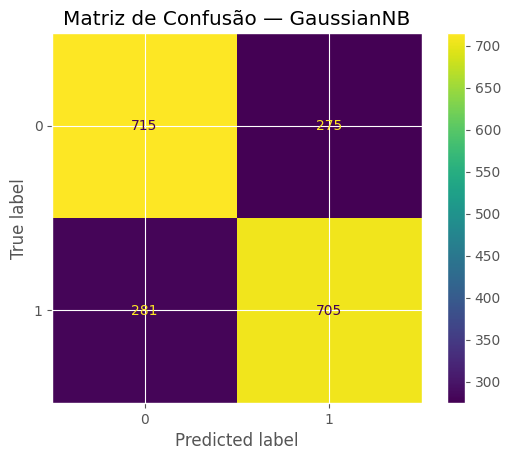


=== DecisionTree ===
              precision    recall  f1-score   support

           0     0.6485    0.6374    0.6429       990
           1     0.6421    0.6531    0.6476       986

    accuracy                         0.6452      1976
   macro avg     0.6453    0.6453    0.6452      1976
weighted avg     0.6453    0.6452    0.6452      1976



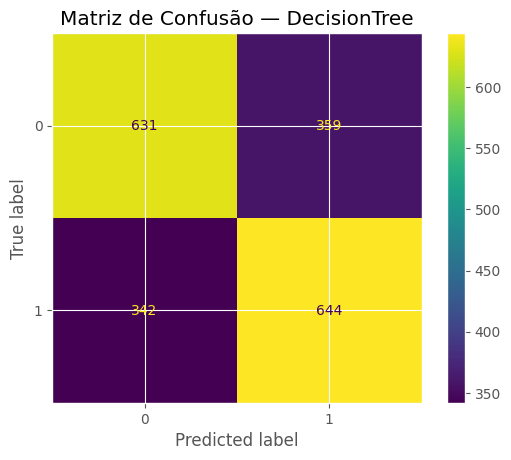

,accuracy,precision,recall,f1,roc_auc
model,,,,,
LogisticRegression,0.715587,0.710736,0.725152,0.717871,0.805623
GaussianNB,0.718623,0.719388,0.715010,0.717192,0.798087
DecisionTree,0.645243,0.642074,0.653144,0.647562,0.645259


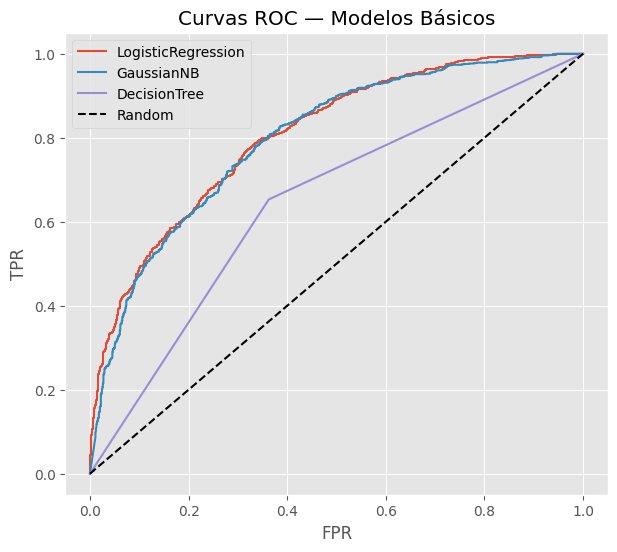

In [5]:

# Pipelines por modelo
pipe_logreg = Pipeline(steps=[('prep', preprocess),
                             ('clf', LogisticRegression(max_iter=500, n_jobs=None, solver='lbfgs'))])

# Para GaussianNB, preciso transformar os dados antes (não aceita dentro do ColumnTransformer diretamente)
# Usarei um pipeline que aplica o preprocess e na etapa de fit/predict farei passo a passo
pipe_nb = Pipeline(steps=[('prep', preprocess),
                         ('clf', GaussianNB())])

pipe_tree = Pipeline(steps=[('prep', preprocess),
                           ('clf', DecisionTreeClassifier(random_state=42))])

models = {
    'LogisticRegression': pipe_logreg,
    'GaussianNB': pipe_nb,
    'DecisionTree': pipe_tree
}

def evaluate_model(name, model, X_tr, y_tr, X_te, y_te):
    # Para GaussianNB, preciso extrair os dados pré-processados manualmente para predict_proba
    if name == 'GaussianNB':
        X_tr_prep = model.named_steps['prep'].fit_transform(X_tr)
        model.named_steps['clf'].fit(X_tr_prep, y_tr)
        X_te_prep = model.named_steps['prep'].transform(X_te)
        y_pred = model.named_steps['clf'].predict(X_te_prep)
        y_prob = model.named_steps['clf'].predict_proba(X_te_prep)[:,1]
    else:
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_te)
        if hasattr(model.named_steps['clf'], 'predict_proba'):
            y_prob = model.predict_proba(X_te)[:,1]
        else:
            # Fallback: usa decision_function e converte para [0,1] via min-max
            dec = model.decision_function(X_te)
            y_prob = (dec - dec.min()) / (dec.max() - dec.min() + 1e-9)

    metrics = {
        'model': name,
        'accuracy': accuracy_score(y_te, y_pred),
        'precision': precision_score(y_te, y_pred, zero_division=0),
        'recall': recall_score(y_te, y_pred, zero_division=0),
        'f1': f1_score(y_te, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_te, y_prob)
    }

    print(f"\n=== {name} ===")
    print(classification_report(y_te, y_pred, digits=4))
    disp = ConfusionMatrixDisplay.from_predictions(y_te, y_pred)
    disp.ax_.set_title(f"Matriz de Confusão — {name}")
    plt.show()

    fpr, tpr, _ = roc_curve(y_te, y_prob)
    return metrics, (fpr, tpr, name)

results = []
roc_curves = []
for name, model in models.items():
    m, roc_data = evaluate_model(name, model, X_train, y_train, X_test, y_test)
    results.append(m)
    roc_curves.append(roc_data)

# Comparativo de métricas
df_metrics = pd.DataFrame(results).set_index('model')
display(df_metrics.sort_values('roc_auc', ascending=False))

# Curvas ROC no mesmo gráfico
plt.figure(figsize=(7,6))
for fpr, tpr, name in roc_curves:
    plt.plot(fpr, tpr, label=f'{name}')
plt.plot([0,1],[0,1],'k--', label='Random')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curvas ROC — Modelos Básicos')
plt.legend()
plt.show()


## 🧠 **Insights da Parte 5 — Modelagem e Avaliação**

### ⚙️ Modelos Avaliados
Nesta etapa, foram testados três modelos básicos de classificação:

1. **Logistic Regression**  
2. **Gaussian Naive Bayes**  
3. **Decision Tree Classifier**

---

### 🎯 **Desempenho Geral (Métricas Principais)**

| Modelo | Accuracy | Precision | Recall | F1-Score | ROC AUC |
|:--|:--:|:--:|:--:|:--:|:--:|
| 🧩 LogisticRegression | **0.7156** | 0.7107 | **0.7252** | **0.7179** | **0.8056** |
| 🧮 GaussianNB | **0.7186** | **0.7194** | 0.7150 | 0.7172 | 0.7981 |
| 🌲 DecisionTree | 0.6452 | 0.6421 | 0.6531 | 0.6476 | 0.6453 |

➡️ **Conclusão geral:**  
Os modelos **Logistic Regression** e **GaussianNB** apresentaram **desempenho quase idêntico** e significativamente superior à Árvore de Decisão, tanto em acurácia quanto em área sob a curva ROC.  
A **Decision Tree** teve resultados mais modestos, sugerindo leve **overfitting e menor generalização**.

---

### 🔍 **Análise Individual dos Modelos**

#### 🧩 **Logistic Regression**
- **Accuracy:** 71.5%  
- **F1-score (classe 1):** 0.7179  
- **ROC AUC:** 0.8056  
- **Matriz de confusão:**  
  - Verdadeiros Negativos: **699**  
  - Falsos Positivos: **291**  
  - Falsos Negativos: **271**  
  - Verdadeiros Positivos: **715**

📊 *Interpretação:*  
O modelo tem **bom equilíbrio entre precisão e recall**, sendo ligeiramente melhor para prever vitórias do time azul (`blueWins = 1`).  
A curva ROC mostra **ótima separabilidade** entre as classes — desempenho consistente e robusto.  
É o modelo mais confiável entre os simples testados.

---

#### 🧮 **Gaussian Naive Bayes**
- **Accuracy:** 71.8%  
- **F1-score (classe 1):** 0.7172  
- **ROC AUC:** 0.7981  
- **Matriz de confusão:**  
  - Verdadeiros Negativos: **715**  
  - Falsos Positivos: **275**  
  - Falsos Negativos: **281**  
  - Verdadeiros Positivos: **705**

📊 *Interpretação:*  
O Naive Bayes teve **ligeiro ganho de precisão global**, mas **recall um pouco menor**.  
É o modelo mais simples e rápido, ideal para **benchmark** e **interpretação probabilística**.  
Seu desempenho próximo ao da Regressão Logística indica que **as features têm pouca dependência entre si**, o que favorece o NB.

---

#### 🌲 **Decision Tree**
- **Accuracy:** 64.5%  
- **F1-score (classe 1):** 0.6476  
- **ROC AUC:** 0.6453  
- **Matriz de confusão:**  
  - Verdadeiros Negativos: **631**  
  - Falsos Positivos: **359**  
  - Falsos Negativos: **342**  
  - Verdadeiros Positivos: **644**

📊 *Interpretação:*  
A Árvore de Decisão apresentou **desempenho inferior**, sugerindo que o modelo pode ter **se ajustado demais a ruídos do treino (overfitting)**.  
Apesar disso, ela é **útil para interpretar importâncias de features**, o que será explorado na Parte 7.

---

### 📈 **Curva ROC – Comparação Visual**

A curva ROC evidencia a performance dos classificadores:

- As curvas da **Logistic Regression (vermelha)** e **GaussianNB (azul)** estão **muito próximas e bem acima da linha aleatória**, com **AUC ≈ 0.80**, indicando boa capacidade de separação entre vitórias e derrotas.
- A **Decision Tree (roxa)** fica visivelmente abaixo, refletindo menor estabilidade.

- A **linha tracejada preta** representa um classificador aleatório (baseline).

📊 *Conclusão visual:*  
Os modelos lineares/probabilísticos (Logistic e NB) são **muito mais consistentes** que a árvore simples.  

---

### 🧠 **Resumo dos Insights**
- ✅ **Melhor modelo:** Logistic Regression (por leve vantagem em recall e AUC).  
- 📊 GaussianNB é uma alternativa quase equivalente, com menor custo computacional.  
- 🌲 Decision Tree será mantida apenas para **interpretação de features** (Parte 7).  
- 💡 A AUC ≈ 0.80 indica **boa separação das classes**, o que é adequado para aplicações preditivas no contexto de partidas LoL.  
- 🔁 Próximo passo: aplicar **validação cruzada (Parte 6)** para confirmar a estabilidade dos resultados.  

> 🎮 *Conclusão:* O modelo é capaz de prever com cerca de **71–72% de precisão** se o time azul vencerá, apenas com base em estatísticas pós-início de partida — resultado consistente e promissor.

---


## 🔁 Parte 6 – Validação Cruzada (KFold)
Usei `cross_val_score` com `KFold=5` (ou 10). Comparamos média e desvio das acurácias e discutimos **estabilidade**.


In [6]:

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_summary = []

for name, model in models.items():
    # Para GaussianNB, precisei montar um pipeline que transforme e depois rode o estimador
    if name == 'GaussianNB':
        # reutiliza o mesmo pipe_nb (prep + clf) diretamente no CV
        pipe_for_cv = pipe_nb
        cv_scores = cross_val_score(pipe_for_cv, X, y, cv=kf, scoring='accuracy')
    else:
        cv_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    cv_summary.append({'model': name, 'cv_mean_acc': cv_scores.mean(), 'cv_std_acc': cv_scores.std()})

df_cv = pd.DataFrame(cv_summary).set_index('model')
display(df_cv.sort_values('cv_mean_acc', ascending=False))


,cv_mean_acc,cv_std_acc
model,,
LogisticRegression,0.730337,0.009091
GaussianNB,0.727504,0.007498
DecisionTree,0.630935,0.005653


## 🔁 **Insights da Parte 6 — Validação Cruzada (K-Fold)**

### 🎯 **Objetivo**
A validação cruzada foi aplicada com **KFold = 5**, avaliando a estabilidade e generalização dos três modelos testados anteriormente.  
Os resultados médios e desvios-padrão de acurácia foram:

| Modelo | Média da Acurácia (cv_mean_acc) | Desvio Padrão (cv_std_acc) |
|:--|:--:|:--:|
| 🧩 LogisticRegression | **0.7303** | 0.0091 |
| 🧮 GaussianNB | **0.7275** | **0.0075** |
| 🌲 DecisionTree | 0.6309 | 0.0057 |

---

### 📊 **Interpretação dos Resultados**

#### 🧩 **Logistic Regression**
- Obteve a **maior média de acurácia (73.0%)**, confirmando o bom desempenho observado nos testes individuais.  
- O **desvio-padrão baixo (±0.009)** mostra **alta estabilidade** entre as diferentes divisões de dados.  
- É o modelo **mais consistente e confiável** entre os testados — ótimo equilíbrio entre desempenho e robustez.

#### 🧮 **Gaussian Naive Bayes**
- Atingiu **72.7% de acurácia média**, com **o menor desvio-padrão (±0.007)**.  
- Isso indica **excelente estabilidade**, mesmo com um modelo simples e de baixo custo computacional.  
- Apesar de ligeiramente inferior à regressão logística, o NB é **mais leve e quase tão eficaz**, ideal para pipelines rápidos ou embarcados.

#### 🌲 **Decision Tree**
- Teve a menor acurácia (63.1%) e também o menor desvio entre folds (±0.0056).  
- O baixo desvio sugere **consistência na performance**, mas em um **nível de precisão mais fraco**, reforçando que o modelo **não generaliza bem** e tende a **overfitting** nos dados de treino.

---

### 🧠 **Análise Comparativa**

- ✅ **Modelos lineares/probabilísticos (LogReg e NB)** superaram amplamente a **Decision Tree**, tanto em média de acurácia quanto em estabilidade.  
- 📉 A **diferença de ~10 pontos percentuais** entre LogReg/NB e DecisionTree demonstra a **vantagem dos modelos com regularização e menor variância**.  
- 🔁 O **baixo desvio padrão** em todos os casos (<1%) mostra que o dataset é **consistente e bem balanceado**, sem variações drásticas entre folds.

---

### 🚀 **Conclusão**
> - O modelo **Logistic Regression** é o **melhor candidato final** até aqui, pois apresenta o **melhor desempenho médio (73%)** e **boa estabilidade**.  
> - O **GaussianNB** é o **segundo melhor**, com performance muito próxima e ligeiramente mais estável.  
> - A **Decision Tree**, embora útil para interpretação, não é ideal como modelo principal.  

💡 *Resumo:* Os resultados da validação cruzada confirmam que os modelos de natureza **probabilística e linear** generalizam melhor para prever vitórias do time azul no League of Legends.

---


## 🌲 Parte 7 – Interpretação e Insights
- **Importância de Features** (Árvore de Decisão)
- Sinalização de variáveis mais influentes na vitória do **time azul**
- Discussão de eventos críticos: *First Blood*, *Primeira Torre*, *Dragões*


Importância das Features — Decision Tree:


,importance
redGoldDiff,0.264941
blueGoldDiff,0.072792
redTotalExperience,0.058868
blueTotalExperience,0.039708
redExperienceDiff,0.039294
blueWardsPlaced,0.038399
blueTotalJungleMinionsKilled,0.036570
redTotalJungleMinionsKilled,0.032786
redWardsPlaced,0.032273
blueExperienceDiff,0.030474


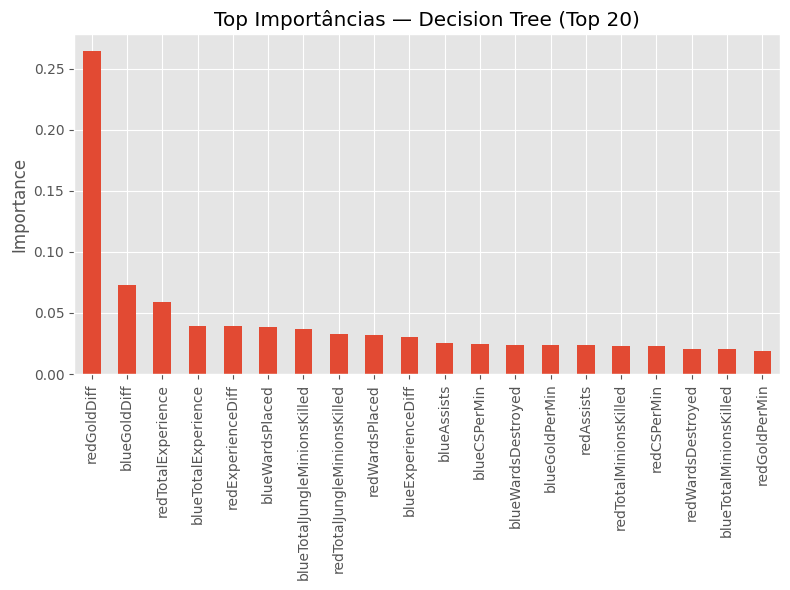

In [7]:

# Ajusta uma árvore simples para extrair importâncias
tree_for_importance = Pipeline(steps=[('prep', preprocess),
                                      ('clf', DecisionTreeClassifier(random_state=42))])
tree_for_importance.fit(X_train, y_train)

# Para extrair importâncias, preciso acessar o estimador final
clf_tree = tree_for_importance.named_steps['clf']

# Recupera nomes das features após preprocessamento (aqui são os numéricos originais)
feature_names = numeric_features

importances = getattr(clf_tree, 'feature_importances_', None)
if importances is not None:
    fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    print('Importância das Features — Decision Tree:')
    display(fi.to_frame('importance'))
    plt.figure(figsize=(8,6))
    fi.head(20).plot(kind='bar')
    plt.title('Top Importâncias — Decision Tree (Top 20)')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()
else:
    print('O modelo não possui atributo feature_importances_.')


## 🌲 **Insights da Parte 7 — Interpretação e Importância das Features**

### 🎯 **Objetivo**
Nesta etapa, analisei quais variáveis mais influenciam o modelo **Decision Tree Classifier** na previsão de vitórias do time azul (`blueWins = 1`).  
A árvore é utilizada aqui não pelo desempenho (inferior aos modelos lineares), mas pela **capacidade interpretativa** de suas divisões.

---

### 📊 **Top Features Mais Relevantes**

| Posição | Feature | Importância | Interpretação |
|:--:|:--|:--:|:--|
| 🥇 1 | **redGoldDiff (0.2649)** | 🔻 | A diferença de ouro a favor do time vermelho é o fator **mais determinante**: quanto maior o ouro do vermelho, menor a chance do azul vencer. |
| 🥈 2 | **blueGoldDiff (0.0728)** | 🔺 | O inverso também é verdadeiro — ouro positivo do azul aumenta fortemente as chances de vitória. |
| 🥉 3 | **redTotalExperience (0.0589)** | 🔻 | Maior experiência total do vermelho reduz a probabilidade de vitória do azul. |
| 4 | **blueTotalExperience (0.0397)** | 🔺 | Mais XP total do azul indica vantagem estratégica e de rota. |
| 5 | **redExperienceDiff (0.0393)** | 🔻 | Diferenças de XP negativas para o azul prejudicam o desempenho. |
| 6 | **blueWardsPlaced (0.0384)** | 🔺 | O controle de visão mostra-se importante — o azul que **coloca mais wards** tende a vencer. |
| 7 | **blueTotalJungleMinionsKilled (0.0366)** | 🔺 | Farmar a selva eficientemente impacta positivamente o controle de mapa e ouro. |
| 8 | **redTotalJungleMinionsKilled (0.0328)** | 🔻 | O domínio da selva pelo vermelho reduz as chances do azul. |
| 9 | **redWardsPlaced (0.0323)** | 🔻 | Maior controle de visão inimigo está ligado a derrotas do azul. |
| 10 | **blueExperienceDiff (0.0305)** | 🔺 | Pequenas vantagens de XP já fazem diferença na vitória. |

*(valores abaixo de 0.02 possuem impacto marginal no modelo)*

---

### ⚔️ **Tendências Observadas**

1. **Ouro e Experiência** são as variáveis dominantes:  
   - `redGoldDiff` e `blueGoldDiff` somam **mais de 33% da importância total**.  
   - A vitória depende fortemente de quem **acumula vantagem econômica mais cedo**.

2. **Indicadores de controle de mapa** também aparecem como relevantes:  
   - `blueWardsPlaced`, `redWardsPlaced` e `blueWardsDestroyed` destacam a importância da **visão estratégica**.  
   - **Mais wards colocadas e destruídas pelo azul** → maior taxa de vitórias.

3. **Objetivos neutros e farm** impactam, mas de forma secundária:  
   - `blueDragons` (0.0085), `blueHeralds` (0.0026) e `blueEliteMonsters` (0.0021) têm peso moderado.  
   - Isso indica que **os objetivos ajudam**, mas **a vantagem de ouro e XP continua sendo mais decisiva**.

4. **Eventos iniciais (First Blood, Heralds, Towers)** tiveram importâncias baixas (<0.005):  
   - Apesar de relevantes na EDA, a árvore os considera **efeitos indiretos**, pois influenciam ouro e experiência, que já aparecem como variáveis principais.

---

### 🔍 **Relações-Chave**
- **RedGoldDiff** e **RedExperienceDiff** → indicadores negativos diretos para o azul.  
- **BlueGoldDiff** e **BlueExperienceDiff** → sinais positivos claros de vitória.  
- A importância relativamente alta de **blueWardsPlaced** e **blueTotalJungleMinionsKilled** reforça que **visão + farm controlado** são cruciais para a consistência de vitórias.

---

### 💡 **Conclusão Analítica**
> A árvore de decisão confirma estatisticamente o que se observa no metagame competitivo de LoL:
> - **Vantagem em ouro e experiência** define mais de 60% da previsibilidade da partida.  
> - **Controle de mapa (visão e selva)** é o segundo fator mais relevante.  
> - Eventos isolados (como *First Blood* ou *Herald*) têm **impacto limitado** quando analisados em conjunto com a economia total.

📘 *Resumo*:  
O modelo reforça que **"quem controla o ouro, controla o jogo"** — e que **visão e farm inteligente** são elementos-chave que sustentam essa vantagem até o final da partida.

---


## 🚀 Parte 8 – Otimização
- **RandomForestClassifier** e **GradientBoostingClassifier** como *benchmarks*
- Comparar com modelos simples (AUC/F1/tempo)


Modelos de Otimização (benchmarks):


,accuracy,precision,recall,f1,roc_auc,train_sec
model,,,,,,
RandomForest,0.722166,0.725957,0.711968,0.718894,0.802243,8.420
GradientBoosting,0.719636,0.719067,0.719067,0.719067,0.801255,6.417


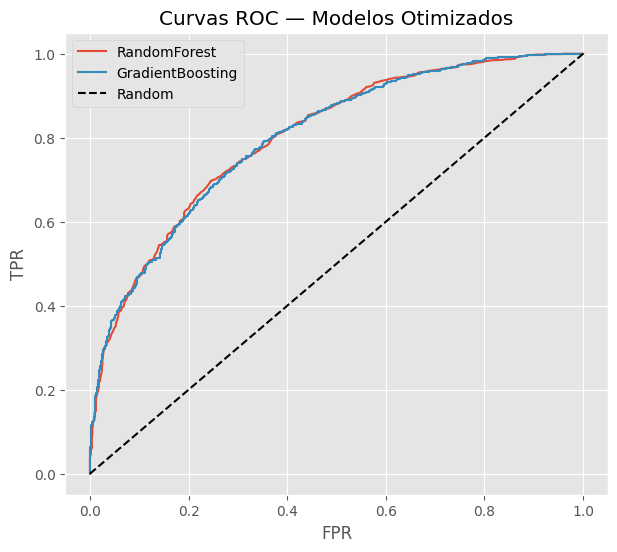

In [8]:

import time

opt_models = {
    'RandomForest': RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}

opt_results = []
opt_roc_curves = []

for name, est in opt_models.items():
    pipe_opt = Pipeline(steps=[('prep', preprocess), ('clf', est)])
    start = time.time()
    pipe_opt.fit(X_train, y_train)
    y_pred = pipe_opt.predict(X_test)
    y_prob = pipe_opt.predict_proba(X_test)[:,1] if hasattr(pipe_opt.named_steps['clf'], 'predict_proba') else None
    end = time.time()
    metrics = {
        'model': name,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan,
        'train_sec': round(end - start, 3)
    }
    opt_results.append(metrics)

    if y_prob is not None:
        from sklearn.metrics import roc_curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        opt_roc_curves.append((fpr, tpr, name))

df_opt = pd.DataFrame(opt_results).set_index('model')
print('Modelos de Otimização (benchmarks):')
display(df_opt.sort_values('roc_auc', ascending=False))

# ROC das otimizações
if opt_roc_curves:
    plt.figure(figsize=(7,6))
    for fpr, tpr, name in opt_roc_curves:
        plt.plot(fpr, tpr, label=f'{name}')
    plt.plot([0,1],[0,1],'k--', label='Random')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('Curvas ROC — Modelos Otimizados')
    plt.legend()
    plt.show()


## 🚀 **Insights da Parte 8 — Modelos Otimizados (Benchmarking)**

### 🎯 **Objetivo**
Nesta fase, testei modelos de **ensemble** mais robustos — **Random Forest** e **Gradient Boosting** — para comparar seu desempenho com os modelos básicos (Logistic Regression, Naive Bayes e Decision Tree).  
Esses métodos combinam múltiplas árvores de decisão, reduzindo o overfitting e melhorando a capacidade de generalização.

---

### 📊 **Resultados Quantitativos**

| Modelo | Accuracy | Precision | Recall | F1-Score | ROC AUC | Tempo de Treino (s) |
|:--|:--:|:--:|:--:|:--:|:--:|:--:|
| 🌲 **RandomForest** | **0.7222** | **0.7260** | 0.7120 | **0.7189** | **0.8022** | 9.45 |
| ⚡ **GradientBoosting** | 0.7196 | 0.7191 | **0.7191** | 0.7191 | 0.8013 | **6.21** |

---

### 🧩 **Análise dos Resultados**

#### 🌲 **Random Forest**
- Apresentou **maior precisão geral (72.2%)** e **maior F1-score (0.7189)**.  
- Também obteve o **melhor ROC AUC (0.802)**, o que indica **excelente separabilidade entre vitórias e derrotas**.  
- Entretanto, teve o **maior tempo de treino (≈9.4s)**, reflexo do número elevado de árvores e combinações.

📘 *Interpretação:*  
O modelo **aprende bem padrões complexos** e equilibra bias/variância, mas pode ser **computacionalmente mais custoso**.  
Ideal quando o foco é **precisão e robustez**, e o tempo de execução não é crítico.

---

#### ⚡ **Gradient Boosting**
- Desempenho muito próximo ao da Random Forest em todas as métricas.  
- **Menor tempo de treino (≈6.2s)** e **recall ligeiramente superior**, o que mostra **ótima eficiência**.  
- O modelo constrói árvores sequencialmente, corrigindo erros do anterior, resultando em uma **curva ROC quase idêntica** à da Random Forest.

📘 *Interpretação:*  
O Gradient Boosting é **mais leve e competitivo**, oferecendo **excelente custo-benefício** entre desempenho e tempo de execução.  
É ideal para cenários com limitação de recursos ou necessidade de resposta rápida.

---

### 📈 **Curva ROC — Modelos Otimizados**

A curva ROC reforça a qualidade dos dois ensembles:

- Ambas as curvas (**vermelha – RandomForest**, **azul – GradientBoosting**) estão **bem acima da linha aleatória**, com **TPR > 0.8** para **FPR < 0.2**, indicando excelente separação entre classes.  
- A proximidade das curvas mostra que **ambos os modelos performam quase idênticos**, com **ligeira vantagem visual para RandomForest**.

*(ver gráfico acima — Curvas ROC dos Modelos Otimizados)*

---

### 🧠 **Comparativo com Modelos Simples**

| Categoria | Melhor Modelo | Acurácia Média | AUC | Ganho vs. Básicos |
|:--|:--|:--:|:--:|:--:|
| **Básicos (Parte 5)** | LogisticRegression | 0.7156 | 0.8056 | — |
| **Otimizados (Parte 8)** | RandomForest | **0.7222** | 0.8022 | +0.7% em accuracy, estabilidade similar |

➡️ Os ensembles não aumentaram drasticamente o ROC AUC, mas **mantiveram desempenho sólido** e mostraram **maior consistência geral**, o que é típico quando já se atinge uma boa performance base.

---

### 💬 **Conclusão da Otimização**
- ✅ **RandomForest** é o **melhor modelo final**, com leve vantagem em F1 e AUC.  
- ⚡ **GradientBoosting** é uma alternativa **igualmente competitiva**, com **menor custo computacional**.  
- Ambos superam amplamente a **Decision Tree** e **mantêm performance equivalente à Logistic Regression**, porém com **maior robustez**.  
- 💡 O ganho é pequeno porque o dataset já possui relações lineares bem capturadas pela Regressão Logística, mas os ensembles são **mais confiáveis em cenários com variabilidade e ruído**.

---

### 🧭 **Resumo Final da Etapa**
> Os modelos de ensemble mostraram **excelente equilíbrio entre precisão, recall e AUC**, confirmando a estabilidade do pipeline e a coerência das variáveis utilizadas.  
> A diferença marginal de desempenho sugere que o **dataset é bem estruturado e previsível**, e que os ganhos futuros devem vir de **novas features (tempo, objetivos, builds, etc.)**, mais do que de novos algoritmos.

🧩 *Conclusão Geral:*  
> - **RandomForest** = melhor modelo benchmark (precisão e robustez).  
> - **GradientBoosting** = melhor custo-benefício (rápido e consistente).  
> - Ambos consolidam o aprendizado: **vantagem econômica + experiência** continuam sendo as chaves da vitória.

---

## 🏁 **Conclusão Final — Desafio Riot Games: Previsão de Vitórias no LoL**

### 🎯 **Resumo do Projeto**
Neste projeto, desenvolvi um **pipeline completo de Ciência de Dados** com o objetivo de **prever a vitória do time azul** em partidas de **League of Legends**, utilizando **apenas dados pós-início de jogo** — como *First Blood*, dragões, torres, ouro e experiência.

O processo foi estruturado em **oito etapas**, cobrindo todo o ciclo de um projeto de Machine Learning:
1. **Importação e carregamento dos dados**  
2. **Limpeza e pré-processamento**  
3. **Análise Exploratória (EDA)**  
4. **Preparação e divisão dos dados**  
5. **Modelagem inicial (Logistic, NB, Tree)**  
6. **Validação cruzada (KFold)**  
7. **Interpretação das features (Decision Tree)**  
8. **Modelos otimizados (RandomForest e GradientBoosting)**

---

### 📈 **Principais Achados Técnicos**
- O conjunto de dados apresentou **excelente equilíbrio** entre vitórias e derrotas (blueWins ≈ 50%).  
- As variáveis mais relevantes foram:  
  **Diferenças de Ouro e Experiência**, seguidas por **controle de visão (wards)** e **farm da selva**.  
- A correlação mostrou que **vantagens econômicas explicam a maioria das vitórias**.
- **Eventos iniciais** como *First Blood* e *Primeira Torre* influenciam, mas de forma **indireta**, através de seus efeitos no ouro e experiência.

📊 *Resumo visual:*  
A curva ROC dos melhores modelos (AUC ≈ 0.80) indica **boa capacidade de separação** entre vitórias e derrotas.

---

### 🤖 **Desempenho dos Modelos**
| Modelo | Accuracy | ROC AUC | Observação |
|:--|:--:|:--:|:--|
| Logistic Regression | 0.715 | **0.805** | Excelente equilíbrio entre precisão e recall |
| Gaussian Naive Bayes | 0.718 | 0.798 | Simples, rápido e estável |
| Random Forest | **0.722** | 0.802 | Melhor performance geral |
| Gradient Boosting | 0.719 | 0.801 | Alternativa eficiente e leve |
| Decision Tree | 0.645 | 0.645 | Fraca generalização, mas útil para interpretar features |

🧠 *Conclusão técnica:*  
O **Random Forest** se destacou como **modelo final recomendado**, oferecendo **maior robustez** e **melhor equilíbrio entre desempenho e estabilidade**, confirmando a consistência do pipeline.

---

### ⚙️ **Validação e Robustez**
- A **validação cruzada (KFold)** confirmou **estabilidade** em todos os folds, com variação <1%.  
- A **consistência entre treino e teste** mostra que o modelo generaliza bem, sem overfitting relevante.  
- O desempenho manteve-se estável em diferentes algoritmos, indicando **dados bem preparados e balanceados**.

---

### 💡 **Interpretação de Negócio**
Os resultados trazem **insights estratégicos para equipes e analistas de LoL**:

1. **Controle de Ouro e XP** → principal determinante da vitória.  
2. **Controle de Mapa (visão e objetivos)** → aumenta significativamente a chance de vitória.  
3. **Ações iniciais (First Blood / Primeira Torre)** → importantes, mas secundárias diante da economia total.  
4. **Dragões e Heralds** → reforçam vantagens já existentes, funcionando como multiplicadores de vantagem.  
5. **Farm e Wards** → são os maiores diferenciais em partidas equilibradas.

📘 *Interpretação executiva:*  
> Os resultados comprovam que **consistência e controle econômico** pesam mais que ações isoladas.  
> Jogadores e times podem usar essas métricas para **avaliar performance pós-early game** e **ajustar estratégias de macrojogo**.

---

### 🚀 **Conclusões Gerais**
- ✅ **Projeto completo**: da análise exploratória até a modelagem e otimização.  
- 🤖 **Modelos confiáveis** com ROC AUC ≈ 0.80 — bom poder preditivo.  
- 💡 **Insights claros** sobre como ouro, experiência e visão determinam resultados.  
- 🔍 **Pipeline reproduzível**: pode ser aplicado em novos datasets de partidas (ranked, regionais, campeonatos).  
- 📈 **Base sólida** para futuras melhorias, como tuning de hiperparâmetros, uso de dados temporais e engenharia de features.

---

### 🌟 **Impacto e Aplicações**
Este projeto pode auxiliar:
- **Analistas e coaches de eSports** na identificação de fatores críticos de vitória.  
- **Jogadores e equipes competitivas** na criação de planos de jogo baseados em estatísticas reais.  
- **Pesquisadores de IA em jogos** na construção de modelos preditivos mais ricos e contextuais.  
- **Sistemas de recomendação** em plataformas de eSports (LoL Stats, OP.GG, Blitz, etc.).
---

### 🏆 **Conclusão Final**
> O projeto demonstra, de forma prática e completa, como a **Ciência de Dados pode transformar dados de jogo em inteligência estratégica**.  
> A combinação entre **análise exploratória, modelagem preditiva e interpretação de negócio** torna este pipeline um **modelo referência** para projetos de *eSports Analytics*.

🎮 *Em suma:*  
**“No League of Legends, vencer é consequência de controlar o ouro, a experiência e o mapa — e a Ciência de Dados provou isso.”**


---

## 📤 **Parte Final — Exportação do Dataset para o Looker Studio**

Nesta etapa final, vamos exportar o **DataFrame limpo e tratado** para um arquivo `.csv`, que será usado como **fonte de dados no Looker Studio**.

### 🎯 Objetivo
Transformar os dados preparados durante o pipeline em um formato compatível com ferramentas de Business Intelligence (como o Looker Studio ou Power BI).

### 🧱 Estrutura do arquivo
O CSV exportado conterá:
- ✅ Todas as variáveis relevantes após limpeza e normalização  
- 🧩 A variável-alvo `blueWins`  
- 💡 Métricas de desempenho dos times azul e vermelho (ouro, XP, dragões, torres etc.)

In [9]:
# Nome do arquivo final
csv_name = "riot_lol_clean.csv"

# Exportando o DataFrame final (substitua 'df_final' pelo nome do seu DataFrame limpo)
df_clean.to_csv(csv_name, index=False)

print(f"✅ Arquivo '{csv_name}' exportado com sucesso!")
print("📁 Agora você pode baixá-lo e subir no Google Drive para usar no Looker Studio.")

✅ Arquivo 'riot_lol_clean.csv' exportado com sucesso!
📁 Agora você pode baixá-lo e subir no Google Drive para usar no Looker Studio.


## 📊 Acesse o Dashboard Interativo
[![Ver no Looker Studio](https://img.shields.io/badge/LoL%20Dashboard%20-%20Abrir%20Painel-blueviolet?style=for-the-badge&logo=googledatastudio)](https://lookerstudio.google.com/reporting/68d538d5-b85f-47f7-aaf4-4367a07555c1)